# 03 - Forecasting baseline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import energy_forecast
from energy_forecast.utils import repo_root
from energy_forecast.preprocessing import load_and_prepare_x, load_and_prepare_y
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.transformations.series.detrend import STLTransformer
from statsmodels.graphics.tsaplots import month_plot, plot_acf

from prophet import Prophet

In [3]:
REPO_ROOT = Path(repo_root())
DATA_PROCESSED = REPO_ROOT / 'data' / 'processed'

TRAIN_PATH = DATA_PROCESSED / 'train.csv'
TEST_PATH = DATA_PROCESSED / 'test.csv'

In [4]:
# x_train = load_and_prepare_x(TRAIN_PATH)
y_train = load_and_prepare_y(TRAIN_PATH)
y_test = load_and_prepare_y(TEST_PATH)

# print(f'{x_train.shape=}, cols={x_train.columns.tolist()}')
print(f'{y_train.shape=}, cols={y_train.columns.tolist()}')
print(f'{y_test.shape=}, cols={y_test.columns.tolist()}')

y_train.shape=(193, 3), cols=['total_energy', 'year', 'month']
y_test.shape=(65, 3), cols=['total_energy', 'year', 'month']


# Univariate forecasting

# Forecasting

## Facebook Prophet

In [8]:
def prepare_prophet_data(df):

prophet_input = (
    y_train
    .reset_index(drop=False)
    .rename(columns={'datetime': 'ds', 'total_energy': 'y'})
)
prophet_input

,ds,y
0,2001-01-01,24.53
1,2001-02-01,22.30
2,2001-03-01,23.62
3,2001-04-01,19.31
4,2001-05-01,17.42
...,...,...
188,2016-09-01,13.48
189,2016-10-01,15.93
190,2016-11-01,18.24
191,2016-12-01,18.84


In [9]:
prophet = Prophet()
prophet.fit(prophet_input)

01:53:11 - cmdstanpy - INFO - Chain [1] start processing
01:53:11 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = prophet.make_future_dataframe(periods=12, freq='MS')
future.tail()

,ds
200,2017-09-01
201,2017-10-01
202,2017-11-01
203,2017-12-01
204,2018-01-01


In [23]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
200,2017-09-01,13.045449,12.125517,13.990359
201,2017-10-01,15.103623,14.294147,16.016961
202,2017-11-01,17.006253,16.052893,17.886899
203,2017-12-01,19.181990,18.245663,20.160963
204,2018-01-01,19.429747,18.520711,20.370436


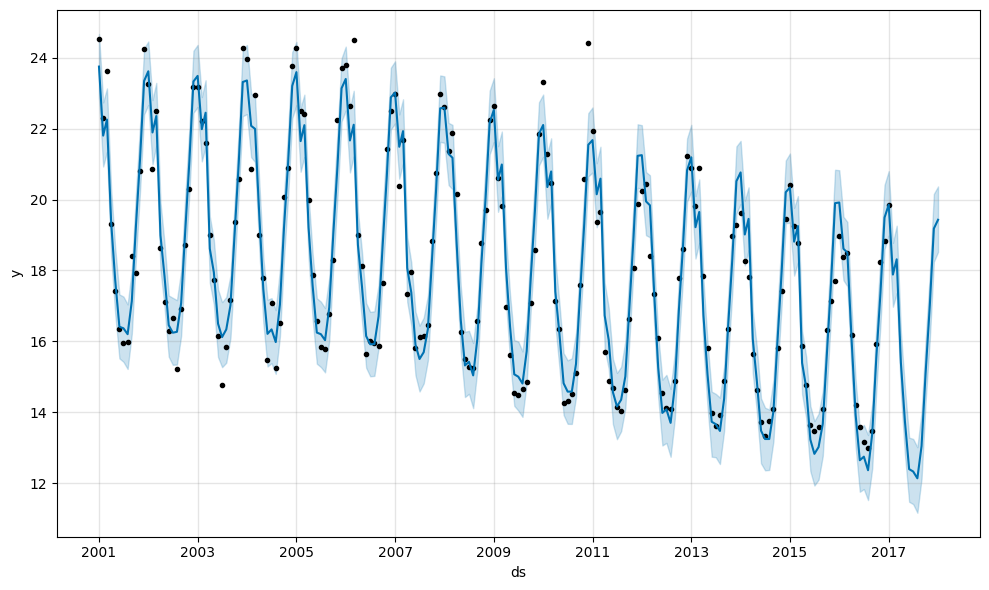

In [24]:
fig1 = prophet.plot(forecast)


## Baseline models

In [6]:
from energy_forecast.forecast.naive import Model
from sktime.forecasting.naive import NaiveForecaster
import mlflow
import os

os.environ['MLFLOW_TRACKING_URI'] = '/workspaces/energy_forecast/mlruns'

In [7]:
model = Model(NaiveForecaster, sp=12)

2022-10-31 01:30:11.757 | DEBUG    | energy_forecast.forecast.naive:__init__:27 - INIT: model intialised


In [8]:
model.params

{'sp': 12, 'strategy': 'last', 'window_length': None}

In [9]:
model.fit(y_train=y_train.to_period('M'), 
          y_test=y_test.to_period('M')
         )

2022-10-31 01:30:12.764 | DEBUG    | energy_forecast.forecast.naive:fit:38 - FIT: running .fit() method
2022-10-31 01:30:12.766 | DEBUG    | energy_forecast.forecast.naive:fit:43 - FIT: y_train.shape=(193, 3)
2022-10-31 01:30:12.781 | DEBUG    | energy_forecast.forecast.naive:fit:48 - FIT: existing log_dir deleted: /workspaces/energy_forecast/logs
2022-10-31 01:30:12.785 | DEBUG    | energy_forecast.forecast.naive:fit:50 - FIT: new log_dir created: /workspaces/energy_forecast/logs
2022-10-31 01:30:12.786 | DEBUG    | energy_forecast.forecast.naive:fit:51 - FIT: creating stdout.log and stderr.log in log_dir
2022-10-31 01:30:13.399 | DEBUG    | energy_forecast.forecast.naive:fit:64 - FIT: starting mlflow tracking
2022-10-31 01:30:13.505 | DEBUG    | energy_forecast.forecast.naive:fit:66 - FIT: model params tracked (3 values)
2022-10-31 01:30:13.506 | DEBUG    | energy_forecast.forecast.naive:fit:68 - FIT: training model
2022-10-31 01:30:13.629 | DEBUG    | energy_forecast.forecast.naive:

In [10]:
os.environ['MLFLOW_TRACKING_URI']

'/workspaces/energy_forecast/mlruns'

## Baseline models

### Mean

### Naive model

## Model evaluation

### Residuals

### Cross validation
Walk forward validation